# Classification Metrics

In the last notebook we used a binary classifier to predict whether patients were diabetic or not. We used *accuracy*, the proportion of how many cases were predicted correctly, as a measure of how well the model performed, but accuracy isn't everything. In this notebook, we will look at alternatives to accuracy that can be much more useful in machine learning.

## Alternative metrics for binary classifiers

Accuracy seems like a sensible metric to evaluate (and to a certain extent it is), but you need to be careful about drawing too many conclusions from the accuracy of a classifier. Suppose only 3% of the population is diabetic. You could create a classifier that just always predicts 0, and it would be 97% accurate - but not terribly helpful in identifying patients with diabetes!

Fortunately, there are some other metrics that reveal more about how our model is performing. Scikit-Learn includes the ability to create a *classification report* that provides more insight than raw accuracy alone.

To get started, run the next cell to load our data and train our model like last time.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load the training dataset
# !wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/diabetes.csv
diabetes = pd.read_csv('data/diabetes.csv')

# Separate features and labels
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
label = 'Diabetic'
X, y = diabetes[features].values, diabetes[label].values


# Split data 70%-30% into training set and test set
X_train: np.ndarray; X_test: np.ndarray; y_train: np.ndarray; y_test: np.ndarray
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

# Train the model
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

predictions = model.predict(X_test)
print('Predicted labels: ', predictions)
print('Actual labels:    ', y_test)

print('Accuracy: ', accuracy_score(y_test, predictions))

Training cases: 10500
Test cases: 4500
Predicted labels:  [0 0 0 ... 0 1 0]
Actual labels:     [0 0 1 ... 1 1 1]
Accuracy:  0.7893333333333333


One of the simplest places to start is a classification report. Run the next cell to see a range of alternate ways to assess our model.

In [4]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      2986
           1       0.72      0.60      0.66      1514

    accuracy                           0.79      4500
   macro avg       0.77      0.74      0.75      4500
weighted avg       0.78      0.79      0.78      4500



The classification report includes the following metrics for each class (0 and 1):

> Note: The header row may not line up with the values.

* *Precision*: Of the predictions the model made for this class, what proportion were correct?
* *Recall*: Out of all of the instances of this class in the test dataset, how many did the model identify?
* *F1-Score*: An average metric that takes both precision and recall into account.
* *Support*: How many instances of this class are there in the test dataset?

The classification report also includes averages for these metrics, including a weighted average that allows for the imbalance in the number of cases of each class.

Because this is a *binary* classification problem, the ***1*** class is considered *positive* and its precision and recall are particularly interesting - these in effect answer the questions:

- Of all the patients the model predicted are diabetic, how many are actually diabetic?
- Of all the patients that are actually diabetic, how many did the model identify?

You can retrieve these values on their own by using the **precision_score** and **recall_score** metrics in Scikit-Learn (which by default assume a binary classification model).


In [5]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:", precision_score(y_test, predictions))
print("Overall Recall:", recall_score(y_test, predictions))

Overall Precision: 0.7242472266244057
Overall Recall: 0.6036988110964333


The precision and recall metrics are derived from four possible prediction outcomes:
* *True Positives*: The predicted label and the actual label are both 1.
* *False Positives*: The predicted label is 1, but the actual label is 0.
* *False Negatives*: The predicted label is 0, but the actual label is 1.
* *True Negatives*: The predicted label and the actual label are both 0.

These metrics are generally tabulated for the test set and shown together as a *confusion matrix*, which takes the following form:

<table style="border: 1px solid black;">
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black;color: black;" bgcolor="lightgray">TN</td><td style="border: 1px solid black;color: black;" bgcolor="white">FP</td>
    </tr>
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black;color: black;" bgcolor="white">FN</td><td style="border: 1px solid black;color: black;" bgcolor="lightgray">TP</td>
    </tr>
</table>

Note that the correct (*true*) predictions form a diagonal line from top left to bottom right - these figures should be significantly higher than the *false* predictions if the model is any good.

In Python, you can use the **sklearn.metrics.confusion_matrix** function to find these values for a trained classifier:


In [6]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print (cm)

[[2638  348]
 [ 600  914]]


Until now, we've considered the predictions from the model as being either 1 or 0 class labels. Actually, things are a little more complex than that. Statistical machine learning algorithms, like logistic regression, are based on *probability*. What actually gets predicted by a binary classifier is the probability that the label is true (**P(y)**) and the probability that the label is false (1 - **P(y)**). A threshold value of 0.5 is used to decide whether the predicted label is a 1 (*P(y) > 0.5*) or a 0 (*P(y) <= 0.5*). You can use the **predict_proba** method to see the probability pairs for each case:

In [7]:
y_scores = model.predict_proba(X_test)
print(y_scores)

[[0.81651727 0.18348273]
 [0.96298333 0.03701667]
 [0.80862083 0.19137917]
 ...
 [0.60688422 0.39311578]
 [0.10672996 0.89327004]
 [0.63865894 0.36134106]]


The decision to score a prediction as a 1 or a 0 depends on the threshold to which the predicted probabilities are compared. If we were to change the threshold, it would affect the predictions; and therefore change the metrics in the confusion matrix. A common way to evaluate a classifier is to examine the *true positive rate* (which is another name for recall) and the *false positive rate* for a range of possible thresholds. These rates are then plotted against all possible thresholds to form a chart known as a *received operator characteristic (ROC) chart*, like this:

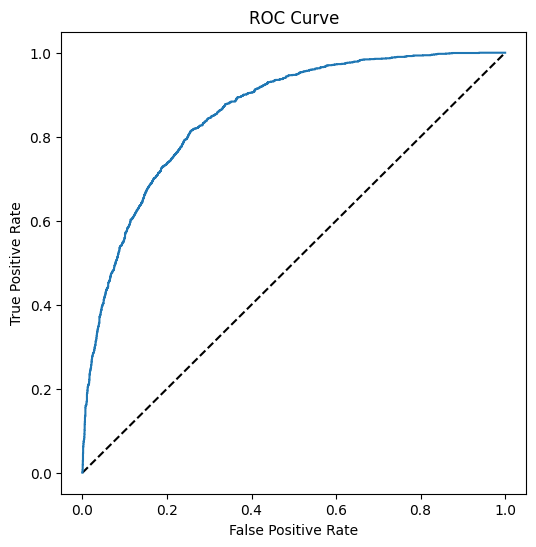

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The ROC chart shows the curve of the true and false positive rates for different threshold values between 0 and 1. A perfect classifier would have a curve that goes straight up the left side and straight across the top. The diagonal line across the chart represents the probability of predicting correctly with a 50/50 random prediction - you want the curve to be higher than that (or your model is no better than simply guessing!).

The area under the curve (*AUC*) is a value between 0 and 1 that quantifies the overall performance of the model. The closer to 1 this value is, the better the model. Scikit-Learn includes a function to calculate this metric, **roc_auc_score**.

In [9]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.8568482508863468


### Perform preprocessing in a pipeline

In this case, the ROC curve and its AUC indicate that the model performs better than a random guess which is not bad considering we performed very little preprocessing of the data.

In practice, it's common to perform some preprocessing of the data to make it easier for the algorithm to fit a model to it. There's a huge range of preprocessing transformations you can perform to get your data ready for modeling, but we'll limit ourselves to a few common techniques:

- Scaling numeric features so they're on the same scale. This prevents features with large values from producing coefficients that disproportionately affect the predictions.
- Encoding categorical variables. For example, by using a *one-hot encoding* technique you can create individual binary (true/false) features for each possible category value.

To apply these preprocessing transformations, we'll make use of a Scikit-Learn feature named *pipelines*. Pipelines enable us to define a set of preprocessing steps that end with an algorithm. You can then apply the entire pipeline to the data, so that the model encapsulates all of the preprocessing steps as well as the regression algorithm. This is useful, because when we want to use the model to predict values from new data, we'll need to apply the same transformations (based on the same statistical distributions and category encodings used with the training data).

>**Note**: The term *pipeline* is used extensively in machine learning, often to mean very different things! In this context, we're using it to refer to pipeline objects in Scikit-Learn.


In [10]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [0,1,2,3,4,5,6]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode the Age column)
categorical_features = [7]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', LogisticRegression(C=1/reg, solver="liblinear"))])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('logregressor',
                 LogisticRegression(C=100.0, solver='liblinear'))])


This pipeline encapsulates the preprocessing steps and also model training.

Let's use the model trained by this pipeline to predict labels for our test set, and compare the performance metrics with the basic model we created previously.

Confusion Matrix:
 [[2667  319]
 [ 406 1108]] 

Accuracy: 0.8388888888888889
Overall Precision: 0.7764540995094604
Overall Recall: 0.7318361955085865
AUC: 0.9202444963329531


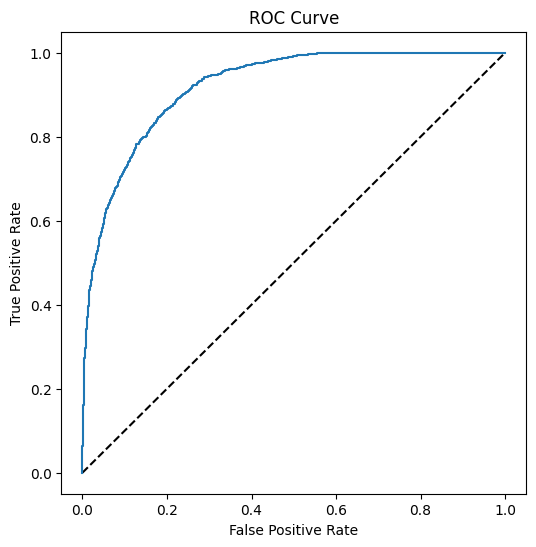

In [11]:
# Get predictions from test data
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:", precision_score(y_test, predictions))
print("Overall Recall:", recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The results do look a little better, so clearly preprocessing the data has made a difference.

### Try a different algorithm

Now let's try a different algorithm. Previously we used a logistic regression algorithm, which is a *linear* algorithm. There are many kinds of classification algorithms we could try, including:

- **Support Vector Machine algorithms**: Algorithms that define a *hyperplane* that separates classes.
- **Tree-based algorithms**: Algorithms that build a decision tree to reach a prediction.
- **Ensemble algorithms**: Algorithms that combine the outputs of multiple base algorithms to improve generalizability.

This time, we'll use the same preprocessing steps as before, but we'll train the model using an *ensemble* algorithm named *Random Forest* that combines the outputs of multiple random decision trees. For more details, see the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees).

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', RandomForestClassifier(n_estimators=100))])

# fit the pipeline to train a random forest model on the training set
model = pipeline.fit(X_train, (y_train))
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('logregressor', RandomForestClassifier())])


Let's look at the performance metrics for the new model.

Confusion Matrix:
 [[2867  119]
 [ 176 1338]] 

Accuracy: 0.9344444444444444
Overall Precision: 0.9183253260123542
Overall Recall: 0.8837516512549538

AUC: 0.9820016528033508


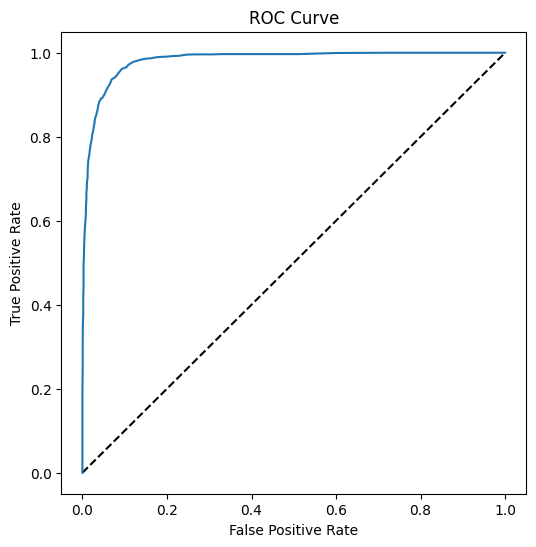

In [13]:
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

That looks better!

### Use the Model for Inferencing
Now that we have a reasonably useful trained model, we can save it for use later to predict labels for new data.

In [14]:
import joblib

# Save the model as a pickle file
filename = './models/diabetes_model.pkl'
joblib.dump(model, filename)

['./models/diabetes_model.pkl']

When we have some new observations with unknown labels, we can load our new model and use it to predict label values.

In [15]:
# Load the model from the file
model: Pipeline = joblib.load(filename)

# predict on a new sample
# The model accepts an array of feature arrays (so you can predict the classes of multiple patients in a single call)
# We'll create an array with a single array of features, representing one patient
X_new = np.array([[2,180,74,24,21,23.9091702,1.488172308,22]])
print ('New sample: {}'.format(list(X_new[0])))

# Get a prediction
pred = model.predict(X_new)

# The model returns an array of predictions - one for each set of features submitted
# In our case, we only submitted one patient, so our prediction is the first one in the resulting array.
print('Predicted class is {}'.format(pred[0]))

New sample: [np.float64(2.0), np.float64(180.0), np.float64(74.0), np.float64(24.0), np.float64(21.0), np.float64(23.9091702), np.float64(1.488172308), np.float64(22.0)]
Predicted class is 1


## Summary

In this notebook, we looked at a range of metrics for binary classification and tried a few algorithms beyond logistic regression. We'll move onto more complex classification problems in the next notebook.